# Basic download data, web map, isochrone, centrality

## Download data with bbox

From bbox http://bboxfinder.com/#-34.439112,-72.050409,-34.379547,-71.982082

In [1]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.16.0'

In [2]:
# define a bounding box n, s, e, w
# copy from bbox WSEN (reorder!) -72.050409,-34.439112,-71.982082,-34.379547
north, south, east, west = -34.379547, -34.439112, -71.982082, -72.050409

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')

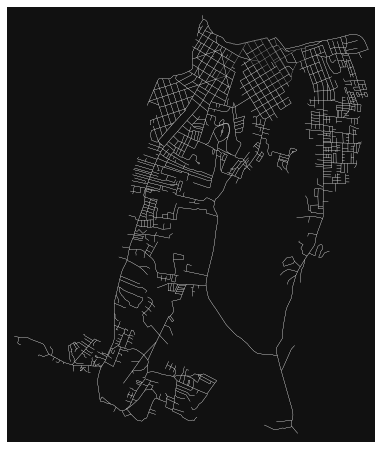

In [3]:
# simple plot
fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2)

In [4]:
# save graph G as geopackage
ox.save_graph_geopackage(G, filepath='./data/network.gpkg')

## Web map

In [5]:
from IPython.display import IFrame

In [6]:
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)

In [7]:
# save as html file then display map as an iframe
filepath = 'data/graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

## Isochrone

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.16.0'

In [4]:
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [5]:
# define a bounding box n, s, e, w
# copy from bbox WSEN (reorder!) -72.050409,-34.439112,-71.982082,-34.379547
north, south, east, west = -34.379547, -34.439112, -71.982082, -72.050409

# download the street network
G = ox.graph_from_bbox(north, south, east, west, network_type=network_type)

In [6]:
# project gprah to UTM
G = ox.project_graph(G)

In [12]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [13]:
# define origin (from geojson.io)
center_node = ox.get_nearest_node(G, (-34.387836330631636, -72.01748371124266))

In [15]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

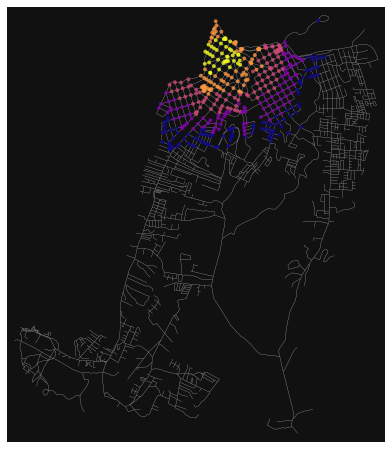

In [16]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')

In [17]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

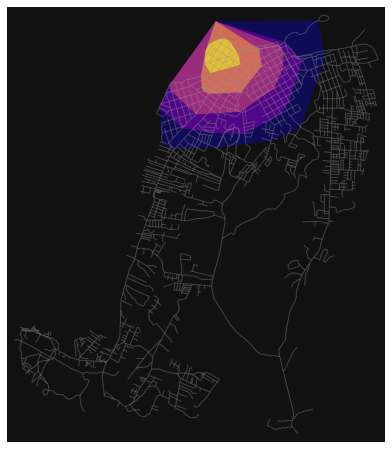

In [18]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

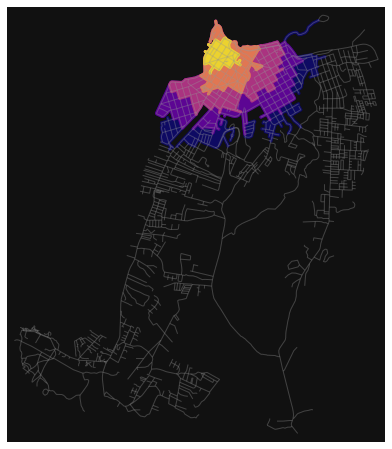

In [19]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()

## Centrality

In [2]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import networkx as nx
import osmnx as ox
import pandas as pd
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.16.0'

In [7]:
# edge betweenness centrality
edge_centrality = nx.edge_betweenness_centrality(G)

In [38]:
edge_centrality

{(314165547, 1080313651): 0.0016604999185174047,
 (314165547, 601329149): 0.002433836917632969,
 (314165547, 3798913076): 0.0006561679790026247,
 (314165626, 3910162089): 0.14556323346777927,
 (314165626, 380466867): 0.04020156909897244,
 (314165626, 1689839228): 0.16453003488382167,
 (314166167, 380467009): 0.004021781267451953,
 (314166167, 1689846931): 0.004074343640031272,
 (314166167, 5295886809): 0.0006561679790026247,
 (314166248, 1689847007): 0.021614772697772833,
 (314166248, 5295953314): 0.0031091505058912948,
 (314166248, 1689846915): 0.09730119923094681,
 (314166248, 1689846860): 0.11157237226118832,
 (314166249, 5282792636): 0.13473236884260087,
 (314166249, 5282792635): 0.13511064558952446,
 (314166433, 1085350766): 0.029153038978190354,
 (314166433, 5295886818): 0.09208144513892708,
 (314166433, 1085350689): 0.062429580628176676,
 (314167115, 1091018915): 0.0052252168413288455,
 (314167115, 380466867): 0.0065229042692710034,
 (314167115, 5295953631): 0.000656167979002624